In [1]:
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import pandas as pd
import xarray as xr
import cftime
import datetime
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
import seaborn as sns; sns.set(color_codes=True)


from sklearn.metrics.pairwise import haversine_distances

grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


## Load Data
### Obs: BGEP moorings, SWIFT buoys, SODA (APL)
### Bootstrap obs (satellite)
### Wave-ice model simulation

In [2]:
# Read in mooring data for 4 time periods from 3 files
bdir = '/glade/work/lettier/BGEP/'
files = ['BGEP-A_AWAC_2012-2013_converted.nc',
         'BGEP-D_AWAC_2014-2015_converted.nc',
         'BGEP-A_AWAC_2017-2018_converted.nc',]        
bounds = [['2012-08','2012-11'],
          ['2015-08','2015-10'],
          ['2017-10','2017-12'],
          ['2018-07','2018-10']]

bds12 = xr.open_dataset(bdir+files[0]).sel(time=slice(bounds[0][0],bounds[0][1]))
bds15 = xr.open_dataset(bdir+files[1]).sel(time=slice(bounds[1][0],bounds[1][1]))
bds17 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[2][0],bounds[2][1]))
bds18 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[3][0],bounds[3][1]))

# pre 2018 model data
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
ice_file = 'cicefsdww3i.cice.h.concat.0068-0084.nc' # monthly ice output
wave_file = 'cicefsdww3i.ww3.sigheight.2000-2016.nc' # daily wave output
mwds = xr.open_dataset(mdir_adj+wave_file)
mwds = mwds.set_coords(['longitude','latitude'])

# 2018 model output
ww18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/ww3.2018.nc').set_coords(['longitude','latitude'])

cice18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/cicefsdww3i.cice.h1.2018.nc') # 2018 model output
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
start = pd.Timestamp(ww18.time.values[0])
end = pd.Timestamp(ww18.time.values[-1])
t = np.linspace(start.value, end.value, len(cice18.time))
t = (pd.to_datetime(t)).round('D')
cice18.time.values = np.asarray(t) # adjust time to be year 2018

# SODA data
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_A_sigWaves.mat_converted.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_B_sigWaves.mat_converted.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_C_sigWaves.mat_converted.nc')


# SWIFT data
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

    
# Get observations from NSIDC bootstrap, regridded to match CICE grid
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2018_cicegrid.nc' # name of regridded file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')

In [3]:
boot

<xarray.Dataset>
Dimensions:                         (ni: 320, nj: 384, time: 13012)
Coordinates:
  * time                            (time) datetime64[ns] 1979-01-02 ... 2018-12-31
    TLON                            (nj, ni) float32 ...
    TLAT                            (nj, ni) float32 ...
Dimensions without coordinates: ni, nj
Data variables:
    aice_d                          (time, nj, ni) float32 ...
    stdev_of_seaice_conc_cdr        (time, nj, ni) float32 ...
    melt_onset_day_seaice_conc_cdr  (time, nj, ni) float32 ...
    qa_of_seaice_conc_cdr           (time, nj, ni) float32 ...
    goddard_merged_seaice_conc      (time, nj, ni) float32 ...
    goddard_nt_seaice_conc          (time, nj, ni) float32 ...
    goddard_bt_seaice_conc          (time, nj, ni) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    history:                   Tue Jan 21 12:40:16 2020: cdo remapbil,o.nc se...
    source:                    ftp://sidads.colorado.edu/DATASETS/nsidc0051_g...
    institution:               NSIDC > National Snow and Ice Data Center
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    program:                   NOAA Climate Data Record Program
    cdr_variable:              seaice_conc_cdr
    software_version_id:       git@bitbucket.org:nsidc/seaice_cdr.git@a4589e0...
    Metadata_Link:             http://nsidc.org/api/metadata?id=g02202
    product_version:           v03r01
    spatial_resolution:        25km
    standard_name_vocabulary:  CF Standard Name Table (v16, 11 October 2010)
    id:                        G02202
    naming_authority:          nsidc.org
    license:                   No constraints on data access or use
    summary:                   This data set provides a passive microwave sea...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SEA ICE > SEA ICE...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Key...
    cdm_data_type:             Grid
    project:                   NOAA/NSIDC passive microwave sea ice concentra...
    creator_url:               http://nsidc.org/
    creator_email:             nsidc@nsidc.org
    processing_level:          NOAA Level 3
    geospatial_lat_min:        31.35
    geospatial_lat_max:        90.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lon_units:      degrees_east
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    contributor_name:          Walt Meier, Ruth Duerr, Florence Fetterer, Jul...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2017-11-18T06:25:29Z
    time_coverage_start:       1979-01-02T00:00:00Z
    time_coverage_end:         1979-01-02T23:59:59Z
    comment:                   The variables seaice_conc_cdr, stdev_of_seaice...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...

### Function to calculate distance to ice edge

In [16]:
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
    lats = iceconc_input.TLAT.values
    lons = iceconc_input.TLON.values


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.001))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # sum the icefracs of 4 neighbor cells at each open water cell
    iceneighborsum = np.nansum(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with non-zero ice neighbor # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighborsum>0)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice
    icewhere = np.where(icefracsnp>0.001)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

### Interpolate cice18 aice to have 6h timesteps

In [23]:
cice18_6h_aice = cice18.aice_d.interp(time=ww18.time.values)
cice18_6h_hi = cice18.hi_d.interp(time=ww18.time.values)

## Find a 2018 wave event

In [24]:
# ww18.sel(time='2018-07')[0].where(cice18_6h.sel)

In [55]:
bds18.peakwaveperiod

<xarray.DataArray 'peakwaveperiod' (time: 2058)>
array([     nan,      nan,      nan, ..., 3.908397,      nan,      nan])
Coordinates:
  * time     (time) datetime64[ns] 2018-07-01T00:31:01.000004 ... 2018-09-24T17:31:00.999998
Attributes:
    long_name:  peak_wave_period
    units:      s

# Comparison of Bootstrap with 2018 Model in Obs areas

### BGEP Mooring (lat 75, lon -150) (2018-07-01, 2018-09-24)

In [5]:
# lowess = sm.nonparametric.lowess
# x = bds18.time
# z = lowess(bds18.icethickness,bds18.time,frac=1/8)
# plt.plot(z)
# sns.regplot(bds18.time.values,bds18.icethickness.values)
# x = np.arange()

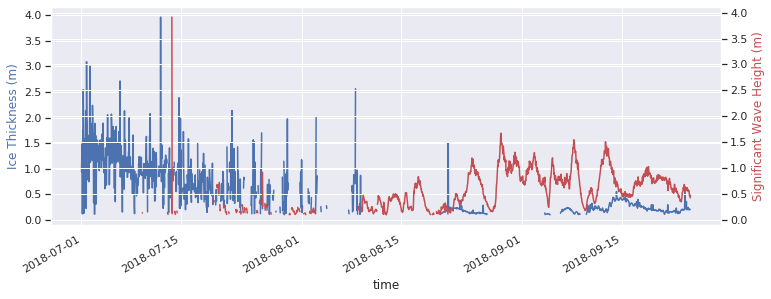

In [107]:
# BGEP
# ice thickness and wave height
fig, ax = plt.subplots(figsize=(12,4))

bds18.icethickness.plot(ax=ax)
ax2 = ax.twinx()
bds18.sigwaveheight.plot(ax=ax2,color='r')
ax.set_ylabel('Ice Thickness (m)',color='b')
ax2.set_ylabel('Significant Wave Height (m)',color='r')
# ax.set_ylim(0.0,6.0)
# ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

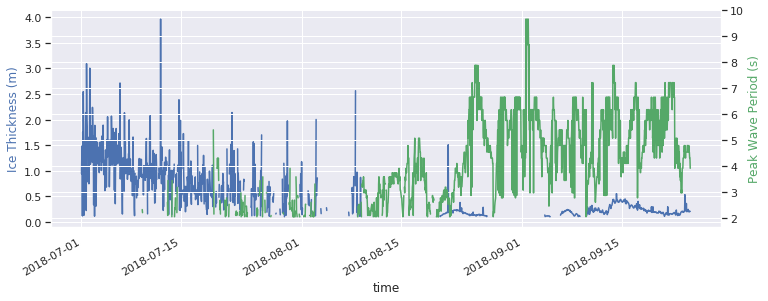

In [108]:
# BGEP
# ice thickness and wave period
fig, ax = plt.subplots(figsize=(12,4))

bds18.icethickness.plot(ax=ax)
ax2 = ax.twinx()
bds18.peakwaveperiod.plot(ax=ax2,color='g')
ax.set_ylabel('Ice Thickness (m)',color='b')
ax2.set_ylabel('Peak Wave Period (s)',color='g')
# ax.set_ylim(0.0,6.0)
# ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

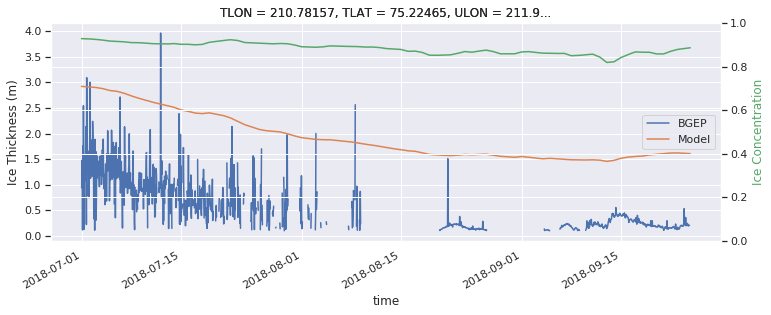

In [123]:
# BGEP and model
# ice thickness
latsel = 350
lonsel = 206
timeslice = slice('2018-07-01','2018-09-24')

fig, ax = plt.subplots(figsize=(12,4))

bds18.icethickness.plot(label='BGEP')
cice18_6h_hi.sel(time=timeslice,nj=latsel,ni=lonsel).plot(label='Model')
ax.set_ylabel('Ice Thickness (m)')
plt.legend(loc=5)

ax2 = ax.twinx()
cice18_6h_aice.sel(time=timeslice,nj=latsel,ni=lonsel).plot(ax=ax2,c='g')
ax2.set_ylabel('Ice Concentration',c='g')
ax2.set_ylim(0.0,1.0)
plt.show(); plt.close()

In [116]:
ww18.hs

<xarray.DataArray 'hs' (time: 1456, nj: 384, ni: 320)>
[178913280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T18:00:00
Dimensions without coordinates: nj, ni
Attributes:
    long_name:      significant height of wind and swell waves
    standard_name:  sea_surface_wave_significant_height
    globwave_name:  significant_wave_height
    units:          m
    valid_min:      0
    valid_max:      32000

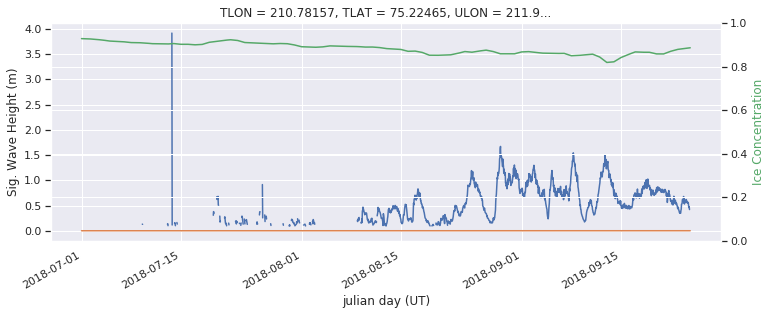

In [117]:
# BGEP and model
# wave height

fig, ax = plt.subplots(figsize=(12,4))

bds18.sigwaveheight.plot()
ww18.hs.sel(time=timeslice,nj=latsel,ni=lonsel).plot()
ax.set_ylabel('Sig. Wave Height (m)')

ax2 = ax.twinx()
cice18_6h_aice.sel(time=timeslice,nj=latsel,ni=lonsel).plot(ax=ax2,c='g')
ax2.set_ylabel('Ice Concentration',c='g')
ax2.set_ylim(0.0,1.0)
plt.show(); plt.close()

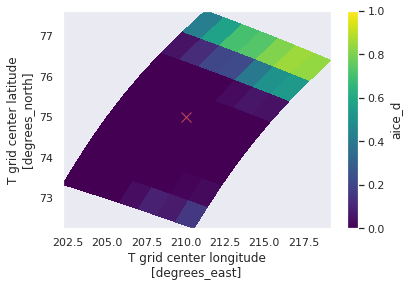

In [4]:
timeslice = slice('2018-09-10','2018-09-24')
latslice = slice(346,354) # 350
lonslice = slice(203,210) # 206

# bootstrap output of ice concentration during a period
boot.sel(time=timeslice,nj=latslice,ni=lonslice).aice_d.mean(dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(210,75,marker='x',c='r',markersize=10)

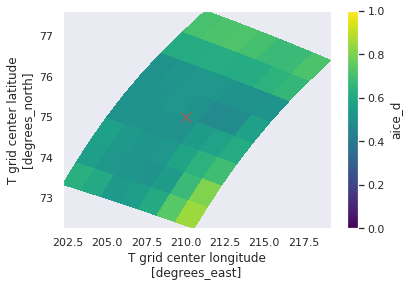

In [5]:
# bootstrap ice during some mooring obs that have ice
timeslice = slice('2018-07-15','2018-07-31')

boot.sel(
    time=timeslice,nj=latslice,ni=lonslice).aice_d.mean(dim='time').plot.pcolormesh(
    'TLON','TLAT',vmin=0,vmax=1)
plt.plot(210,75,marker='x',c='r',markersize=10)

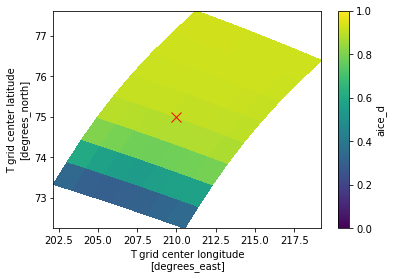

In [78]:
# compare model output of ice cover during same time period
cice18.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.pcolormesh(
    'TLON','TLAT',vmin=0,vmax=1)
plt.plot(210,75,marker='x',c='r',markersize=10)

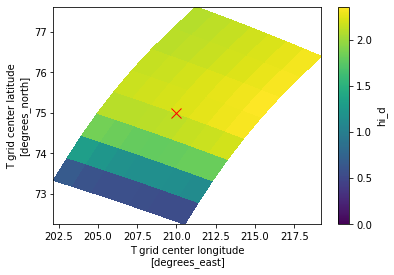

In [80]:
# model output of ice thickness during same time period
cice18.hi_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.pcolormesh(
    'TLON','TLAT',vmin=0)
plt.plot(210,75,marker='x',c='r',markersize=10)

#### Model vs. Bootstrap over BGEP region of interest for each time period

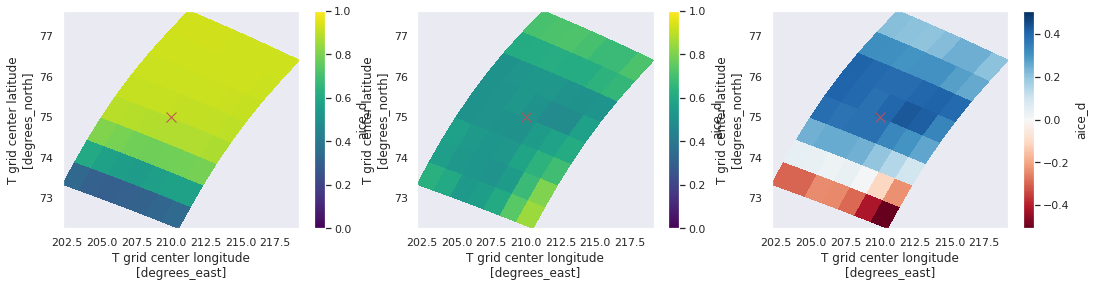

<Figure size 432x288 with 0 Axes>

In [27]:
# Model vs bootstrap: aice
fig = plt.figure(figsize=(18,4))

modelplot = cice18.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time')
bootplot = boot.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time')
diffplot = modelplot - bootplot

# model
ax1 = plt.subplot(1,3,1)
modelplot.plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1,ax=ax1)
plt.plot(210,75,marker='x',c='r',markersize=10)

# boot
ax2 = plt.subplot(1,3,2)
bootplot.plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1,ax=ax2)
plt.plot(210,75,marker='x',c='r',markersize=10)

# diff
ax3 = plt.subplot(1,3,3)
diffplot.plot.pcolormesh('TLON','TLAT',ax=ax3,cmap='RdBu',norm=DivergingNorm(0))
plt.plot(210,75,marker='x',c='r',markersize=10)


plt.show()
plt.tight_layout()

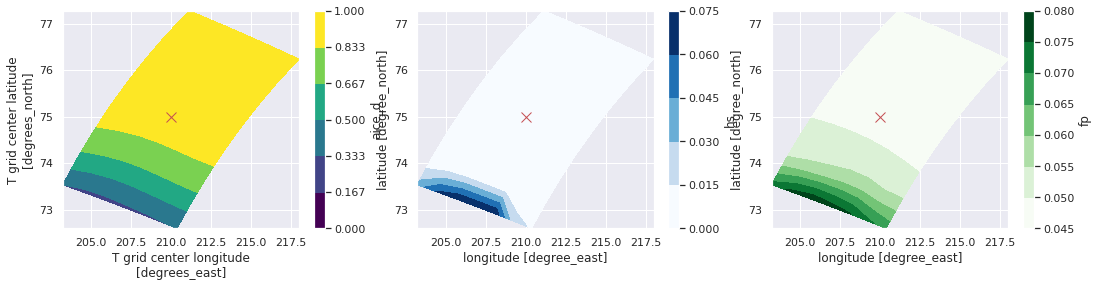

<Figure size 432x288 with 0 Axes>

In [32]:
# Model ice and waves
fig = plt.figure(figsize=(18,4))

# aice
ax1 = plt.subplot(1,3,1)
cice18.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.contourf(
    'TLON','TLAT',vmin=0,vmax=1,ax=ax1)
plt.plot(210,75,marker='x',c='r',markersize=10)

# boot
ax2 = plt.subplot(1,3,2)
ww18.hs.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.contourf(
    'longitude','latitude',cmap='Blues',ax=ax2)
plt.plot(210,75,marker='x',c='r',markersize=10)

# diff
ax3 = plt.subplot(1,3,3)
ww18.fp.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.contourf(
    'longitude','latitude',cmap='Greens',ax=ax3)
plt.plot(210,75,marker='x',c='r',markersize=10)


plt.show()
plt.tight_layout()

In [22]:
ww18

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 1456)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-30T18:00:00
Dimensions without coordinates: ni, nj
Data variables:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
    MAPSTA     (nj, ni) int16 ...
    dpt        (time, nj, ni) float32 ...
    uwnd       (time, nj, ni) float32 ...
    vwnd       (time, nj, ni) float32 ...
    ast        (time, nj, ni) float32 ...
    ice        (time, nj, ni) float32 ...
    hs         (time, nj, ni) float32 ...
    lm         (time, nj, ni) float32 ...
    t02        (time, nj, ni) float32 ...
    t0m1       (time, nj, ni) float32 ...
    t01        (time, nj, ni) float32 ...
    fp         (time, nj, ni) float32 ...
    dir        (time, nj, ni) float32 ...
    spr        (time, nj, ni) float32 ...
    dp         (time, nj, ni) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20180101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2018-01-01 00:00:00
    stop_date:                     2018-01-01 18:00:00
    history:                       Wed Apr 29 17:19:29 2020: ncrename -d long...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

### SODA A

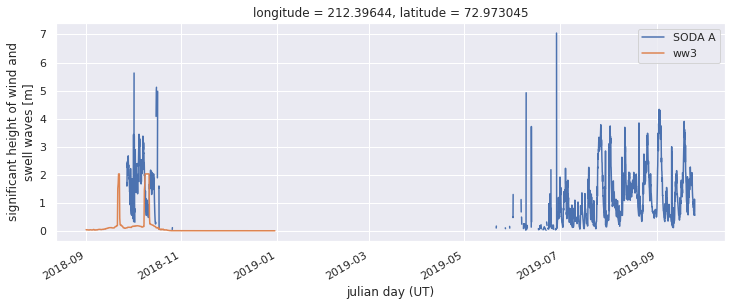

In [181]:
fig, ax = plt.subplots(figsize=(12,4))
sodaA.sigwaveheight.plot(label='SODA A',ax=ax)
ww18.hs.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3',ax=ax)
plt.legend()

# ax2 = ax.twinx()
# cice18.aice_d.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(ax=ax2,color='r')

# ax.set_ylabel('Significant Wave Height (m)')
# ax2.set_ylabel('Ice Concentration',color='r')
# ax.set_ylim(0.0,6.0)
# ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

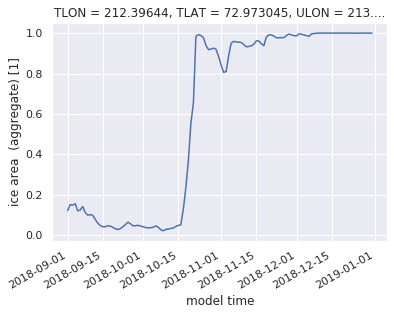

In [184]:
cice18.aice_d.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3')

In [ ]:
sodaA.sigwaveheight.sel(time=sodaAtime).plot()
ww18.hs.sel(time=sodaAtime,nj=347,ni=210).plot()

In [158]:
sodaA

<xarray.Dataset>
Dimensions:             (freq_wavespectra: 42, time: 4362)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.4902
  * time                (time) datetime64[ns] 2018-09-27 ... 2019-09-25T10:00:00
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 ...
    wavespectra_a1      (time, freq_wavespectra) float64 ...
    wavespectra_b1      (time, freq_wavespectra) float64 ...
    wavespectra_a2      (time, freq_wavespectra) float64 ...
    wavespectra_b2      (time, freq_wavespectra) float64 ...
    wavespectra_check   (time, freq_wavespectra) float64 ...
    lat                 (time) float64 73.0 73.0 73.0 73.0 ... 73.0 73.0 73.0
    lon                 (time) float64 -148.3 -148.3 -148.3 ... -148.3 -148.3
    sigwaveheight       (time) float64 ...
    peakwaveperiod      (time) float64 ...
    peakwavedirT        (time) float64 ...
Attributes:
    description:        sigWaves
    data:               SODA cruise, Sam Brenner, APL
    netcdf_created_by:  Lettie Roach, 2020, UW

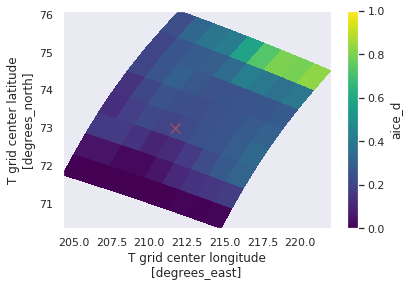

In [164]:
sodaAtime = slice('2018-09-27','2018-10-20')
sodalatslice = slice(344,352)
sodalonslice = slice(206,215)
# lat = 73, lon = 211.7
# cice nj = 347, ni = 211

# bootstrap output of ice concentration during a period
boot.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).aice_d.mean(
    dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

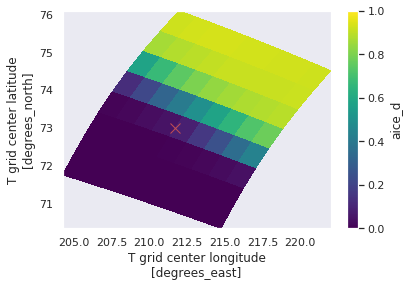

In [156]:
# model output of ice concentration during period
cice18.aice_d.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

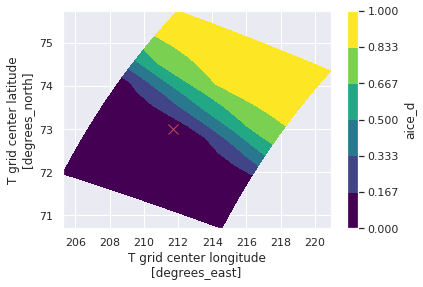

In [162]:
# model output of ice concentration during period
cice18.aice_d.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(dim='time').plot.contourf('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

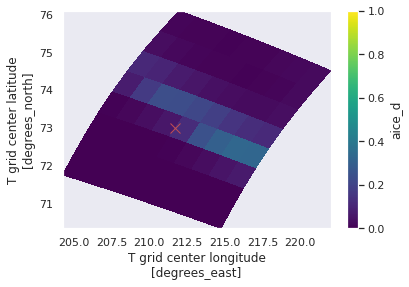

In [183]:
# model output of ice concentration during period
cice18.aice_d.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).std(dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

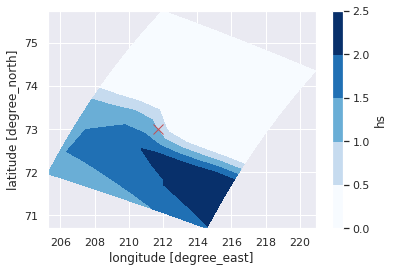

In [166]:
# model output of wave height during period
ww18.hs.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(
    dim='time').plot.contourf('longitude','latitude',cmap='Blues')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

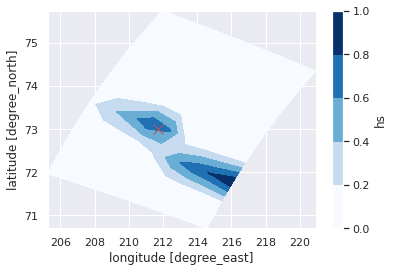

In [170]:
# model output of wave height during period
ww18.hs.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).std(
    dim='time').plot.contourf('longitude','latitude',cmap='Blues')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

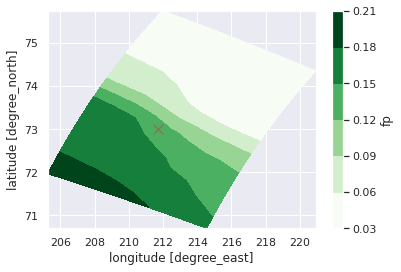

In [173]:
# model output of wave period during period
ww18.fp.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(
    dim='time').plot.contourf('longitude','latitude',cmap='Greens')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

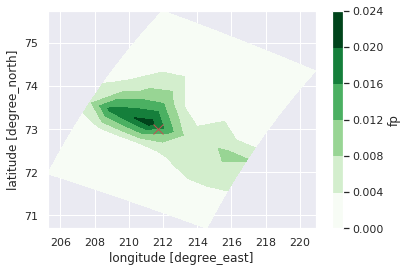

In [172]:
# model output of wave period during period
ww18.fp.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).std(
    dim='time').plot.contourf('longitude','latitude',cmap='Greens')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

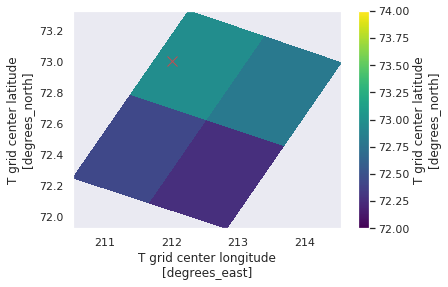

In [134]:
# tool for locating model area

latslice = slice(346,348) # 350
lonslice = slice(210,212) # 206
# cice18.TLAT.plot(vmin=72,vmax=74)
# cice18.TLAT.sel(nj=latslice,ni=lonslice).plot(vmin=72,vmax=74)
# model output of ice thickness during same time period
cice18.TLAT.sel(
    nj=latslice,ni=lonslice).plot.pcolormesh(
    'TLON','TLAT',vmin=72,vmax=74)
plt.plot(212,73,marker='x',c='r',markersize=10)

## Model vs. Bootstrap for each month

In [13]:
# calculate monthly means for 2018; model and bootstrap
timeslice = slice('2018-01-01','2018-12-31')
latslice = slice(300,384)
left = cice18.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').mean(dim='time')
right = boot.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').mean(dim='time')
leftsd = cice18.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').std(dim='time')
rightsd = boot.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').std(dim='time')

diff = left - right

# hack to fix coordinates when taking difference
diff.ULON[:] = left.TLON
diff.ULAT[:] = left.TLAT

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


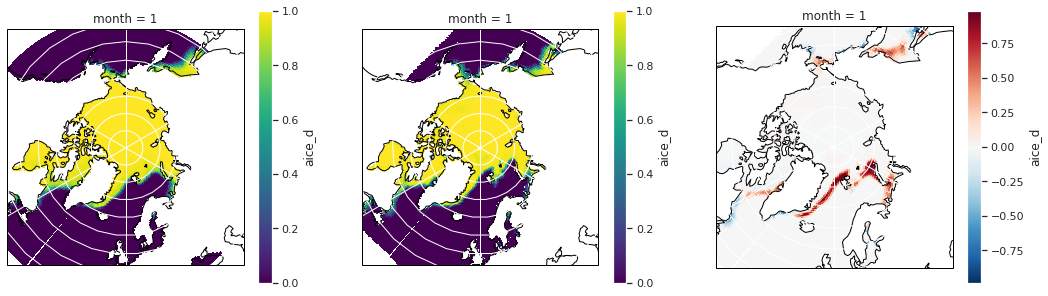

<Figure size 432x288 with 0 Axes>

In [49]:
# January
fig = plt.figure(figsize=(18,5))
monthsel = 1

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.gridlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.gridlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

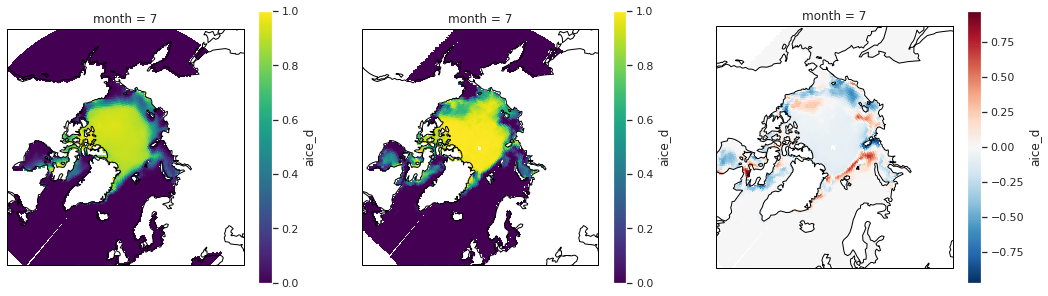

<Figure size 432x288 with 0 Axes>

In [32]:
# July
fig = plt.figure(figsize=(18,5))
monthsel = 7

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

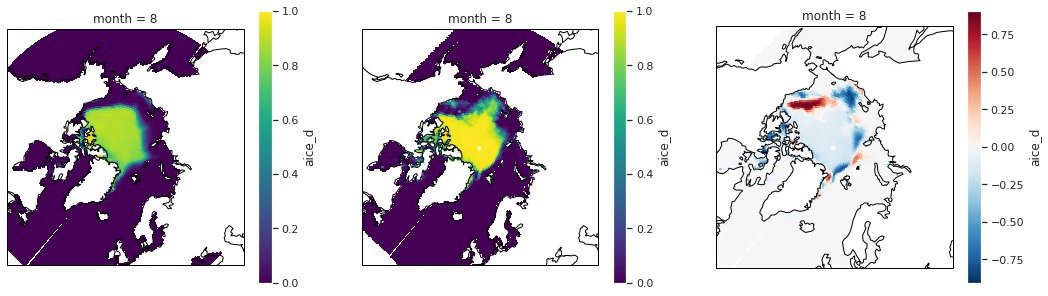

<Figure size 432x288 with 0 Axes>

In [45]:
# Aug
fig = plt.figure(figsize=(18,5))
monthsel = 8

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

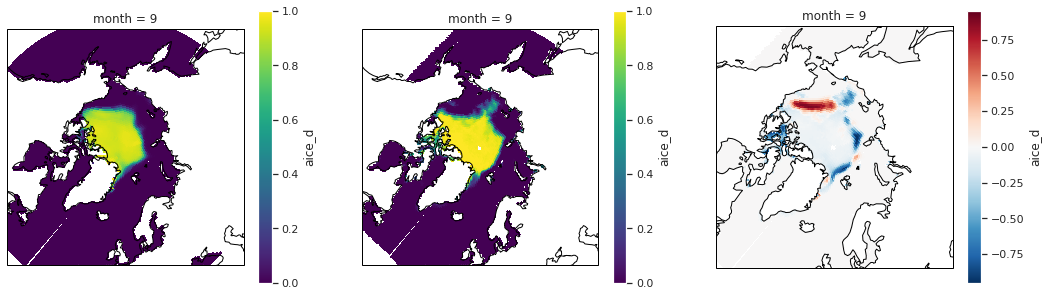

<Figure size 432x288 with 0 Axes>

In [35]:
# Sep
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

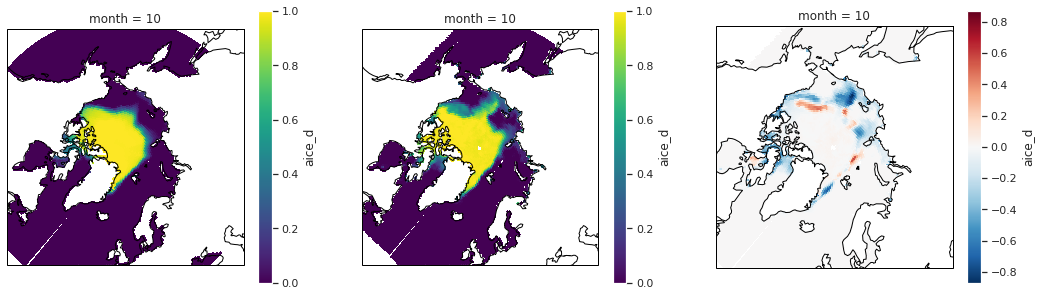

<Figure size 432x288 with 0 Axes>

In [35]:
# Oct
fig = plt.figure(figsize=(18,5))
monthsel = 10

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

### Run distance calculation for one of these months

In [5]:
dist_model = icedistance(left.sel(month=9))
dist_model = xr.DataArray(dist_model,coords=left.sel(month=9).coords)

dist_boot = icedistance(right.sel(month=9))
dist_boot = xr.DataArray(dist_boot,coords=left.sel(month=9).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


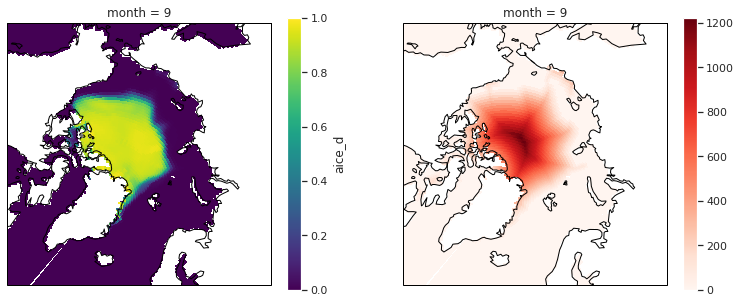

<Figure size 432x288 with 0 Axes>

In [14]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

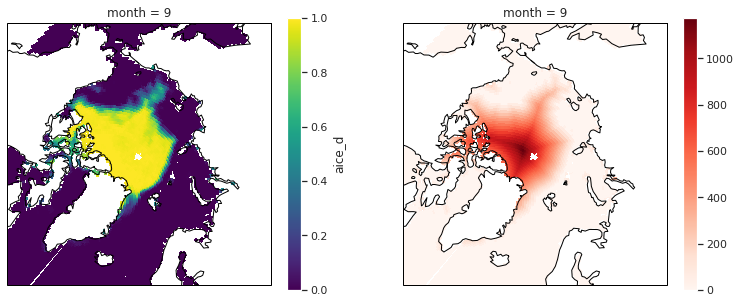

<Figure size 432x288 with 0 Axes>

In [48]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_boot.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

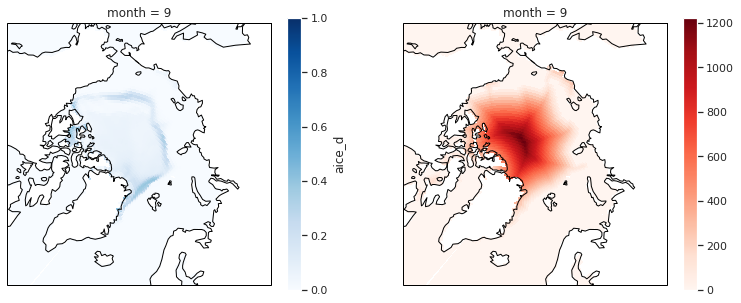

<Figure size 432x288 with 0 Axes>

In [16]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
leftsd.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='Blues')

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

### Compare ice, waves, distance

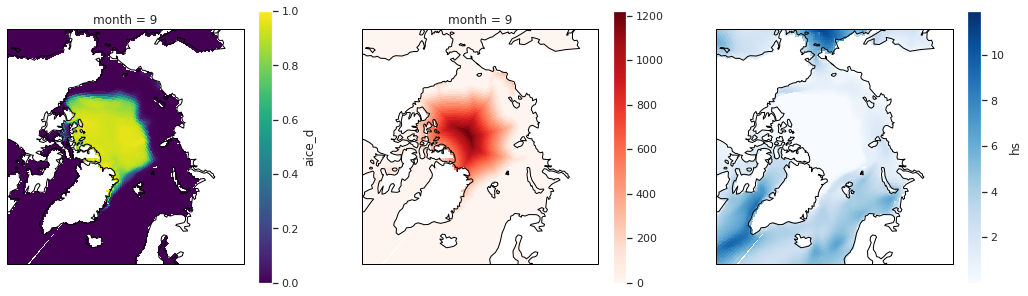

<Figure size 432x288 with 0 Axes>

In [59]:
# Sep: wave mean hs
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.hs.sel(time=slice('2018-09-01','2018-09-30')).mean(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Blues')


plt.show()
plt.tight_layout()

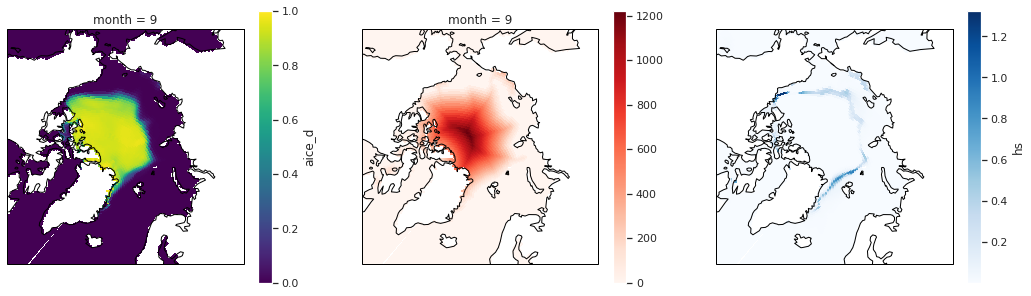

<Figure size 432x288 with 0 Axes>

In [12]:
# Sep: wave stdev
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.hs.sel(time=slice('2018-09-01','2018-09-30')).std(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Blues')


plt.show()
plt.tight_layout()

In [ ]:
# Sep: wave stdev
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
leftsd.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.hs.sel(time=slice('2018-09-01','2018-09-30')).std(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Blues')


plt.show()
plt.tight_layout()

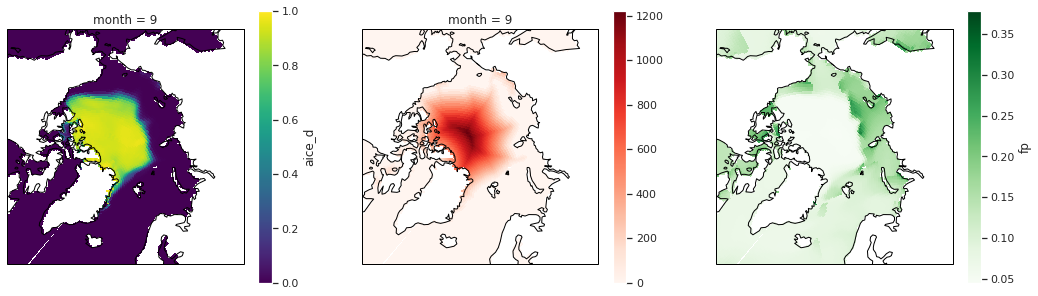

<Figure size 432x288 with 0 Axes>

In [61]:
# Sep: mean fp
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.fp.sel(time=slice('2018-09-01','2018-09-30')).mean(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Greens')


plt.show()
plt.tight_layout()

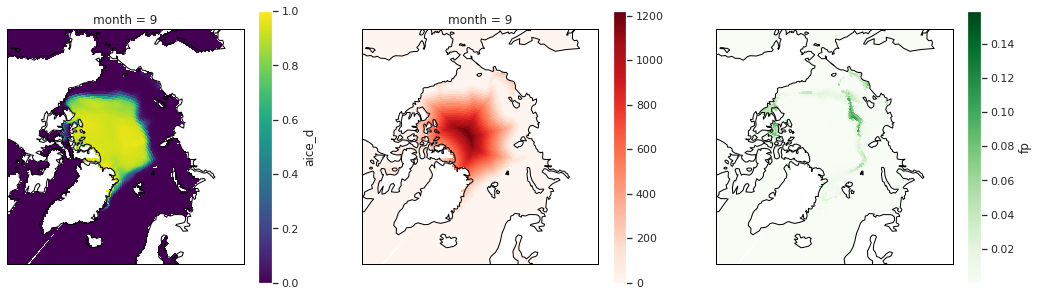

<Figure size 432x288 with 0 Axes>

In [63]:
# Sep: stdev fp
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.fp.sel(time=slice('2018-09-01','2018-09-30')).std(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Greens')


plt.show()
plt.tight_layout()